# Where to open a restaurant in Helsinki

## 1 Introduction
### 1.1 Background

**Helsinki** is the capital city of Finland with a population of 657,674. Together with the cities of Espoo, Vantaa, and Kauniainen, and surrounding commuter towns, Helsinki forms the Greater Helsinki metropolitan area (Uusimaa), which has a population of over 1.5 million. This area is the country's most important center for politics, education, finance, culture, and research. The urbanization and development of the uusimaa area has brought great opportunities for the tertiary sectory business, including catering. Considering someone is seeking for a suitable place in Helsinki to open a restaurant, he or she must be interested in how restaurants are situated in this city, the types of restaurants and the surrounding venues of the restaurants, i.e. other venues in the same neighborhood. My project will provide an analysis of the 60 neighborhoods in Helsinki area, mainly focusing on the restaurants and other popular venues in each neighborhood. The neighborhoods will finally be segmented into several clusters based on the venues situation. For those seeking for a suitble location to open a restaurant, this analysis may provide some clues.

### 1.2 Data description

The data that will be used in this project include:\
-Subdivision (neighborhoods) of Helsinki, collected from wikipedia page [1].\
-The center coordinates of each neighborhood, collected from LatLong.net [2].\
-The most common venues in each neighborhood, collected from Foursquare API [3].

## 2 Methodology

### 2.1 Data preparation

2.1.1 Prepare libaries needed for data collection, pre-processing and modeling

In [2]:
# import libraries
import numpy as np 
import pandas as pd 
import requests # library to handle requests
!pip install bs4
from bs4 import BeautifulSoup

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

     |████████████████████████████████| 122kB 6.5MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py36h5fab9bb_1         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    openssl-1.1.1j             |       h7f98852_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

  geographicl

2.1.2 Get the neighborhood data from wikipedia using BeautifulSoup

In [3]:
# Use Webscraping to Extract data
url = 'https://en.wikipedia.org/wiki/Subdivisions_of_Helsinki'
data = requests.get(url)

soup= BeautifulSoup(data.content, "html.parser")
helsinki_neiborhood_raw = soup.find_all("div", {"class": "div-col"})[0].find_all("li")

df = pd.DataFrame(columns=["Code","Neighborhood","Codelen"])
for row in helsinki_neiborhood_raw:
    col = row.get_text().split(" ") 
    code = col[0] 
    neighborhood = col[1] 
    codelen = len(col[0]) #length of the code
    df= df.append({"Code":code, "Neighborhood":neighborhood,"Codelen":codelen },ignore_index = True)

df=df[df.Codelen!=3] #remove rows with sub-neighborhood (Column "Code" has values with three digit)
df.drop(['Codelen','Code'], axis=1, inplace=True) #drop colmn 'Codelen' and'Code'
df.reset_index(drop=True, inplace=True) 
df.replace({"Ultuna\n591":"Ultuna"}, inplace=True) #fix data of row 58
helsinki_neighborhood = df
helsinki_neighborhood

,Neighborhood
0,Kruununhaka
1,Kluuvi
2,Kaartinkaupunki
3,Kamppi
4,Punavuori
5,Eira
6,Ullanlinna
7,Katajanokka
8,Kaivopuisto
9,Sörnäinen


2.1.3 Get the center coordinates for each neighborhood from LatLong.net. I have downloaded the csv file from LatLong.net.

In [4]:
geocodes = pd.read_csv('helsinki_geocodes.csv', sep=';')
geocodes.head()

,Neighborhood,Latitude,Longitude
0,Kruununhaka,60.17164,24.95658
1,Kluuvi,60.17047,24.94654
2,Kaartinkaupunki,60.16486,24.94940
3,Kamppi,60.16739,24.93108
4,Punavuori,60.16147,24.93726


2.1.4 Merge the geocodes dataframe with helsinki_neighborhood dataframe

In [7]:
helsinki_neighborhood_geo = pd.merge(helsinki_neighborhood, geocodes, on =['Neighborhood'])
helsinki_neighborhood_geo

,Neighborhood,Latitude,Longitude
0,Kruununhaka,60.171640,24.956580
1,Kluuvi,60.170470,24.946540
2,Kaartinkaupunki,60.164860,24.949400
3,Kamppi,60.167390,24.931080
4,Punavuori,60.161470,24.937260
5,Eira,60.156540,24.938170
6,Ullanlinna,60.157490,24.949480
7,Katajanokka,60.166460,24.969350
8,Kaivopuisto,60.158000,24.959770
9,Sörnäinen,60.186640,24.967590


### 2.2 Explore and cluster the neighborhoods in Helsinki

2.2.1 Use geopy library to get the latitude and longitude values of Helsinki

In [8]:
address = 'Helsinki, FI'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Helsinki are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Helsinki are 60.1674881, 24.9427473.


2.2.2 Visualize the neighborhoods in Helsinki

In [9]:
# create map of Toronto using latitude and longitude values
map_helsinki = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(helsinki_neighborhood_geo['Latitude'], helsinki_neighborhood_geo['Longitude'], helsinki_neighborhood_geo['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_helsinki)  
    
map_helsinki

2.2.3 Utilize the Foursquare API to get the venues data for each neighborhood

In [10]:
#Degine Foursquare API credentials
CLIENT_ID = 'RJUXTLJHV2SXEUC5UDBZAQJWGIN1DR3RFACWJQY5J222RZME' 
CLIENT_SECRET = '1EH4YNDCQ5JZ4ZQCWKPGSK1Q1YOFJPZLJGQNFQDD4W5DMHIZ' 
VERSION = '20180605'
LIMIT = 100 #limit the response for each neighborhood to 100

In [11]:
#define a function to get the venue data of Helsinki neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=400):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
#Run the above function and create a new dataframe called helsinki_venues
helsinki_venues = getNearbyVenues(names=helsinki_neighborhood_geo['Neighborhood'],
                                   latitudes=helsinki_neighborhood_geo['Latitude'],
                                   longitudes=helsinki_neighborhood_geo['Longitude']
                                  )

In [13]:
helsinki_venues.shape #Check how many venues are collected

(1233, 7)

In [16]:
helsinki_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kruununhaka,60.17164,24.95658,Kuurna,60.170128,24.958564,Scandinavian Restaurant
1,Kruununhaka,60.17164,24.95658,Papu Cafe,60.173040,24.956453,Café
2,Kruununhaka,60.17164,24.95658,Korea House,60.172910,24.956436,Korean Restaurant
3,Kruununhaka,60.17164,24.95658,Cafe LOV,60.171284,24.956623,Café
4,Kruununhaka,60.17164,24.95658,Bei Fang,60.171602,24.953990,Chinese Restaurant


2.2.4 Explore the neighborhoods by analysing venues data

a) Check how many venues were returned for each neighborhood

In [14]:
helsinki_venues.groupby('Neighborhood').count()['Venue'].sort_values(ascending=False)

Neighborhood
Ulkosaaret                 100
Kamppi                      97
Kaartinkaupunki             74
Aluemeri                    59
Taka-Töölö                  52
Punavuori                   51
Kruununhaka                 51
Salmenkallio                47
Kluuvi                      45
Ullanlinna                  41
Katajanokka                 41
Vallila                     38
Herttoniemi                 31
Länsisatama                 29
Pasila                      28
Alppiharju                  24
Vuosaari                    22
Lauttasaari                 22
Suomenlinna                 21
Toukola                     20
Laakso                      20
Eira                        19
Etu-Töölö                   18
Munkkiniemi                 18
Kaivopuisto                 16
Sörnäinen                   15
Pukinmäki                   15
Kaarela                     14
Hermanni                    13
Mustikkamaa-Korkeasaari     13
Malmi                       12
Konala                    

b) Find out how many unique categories can be curated from all the returned venues

In [15]:
print('There are {} uniques categories.'.format(len(helsinki_venues['Venue Category'].unique())))

There are 241 uniques categories.


c) Arrange the data so that each venue categoroy will be in one column

In [16]:
# one hot encoding
helsinki_onehot = pd.get_dummies(helsinki_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
helsinki_onehot['Neighborhood'] = helsinki_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [helsinki_onehot.columns[-1]] + list(helsinki_onehot.columns[:-1])
helsinki_onehot = helsinki_onehot[fixed_columns]

helsinki_onehot.head()

,Neighborhood,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auditorium,Bagel Shop,...,Video Game Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Kruununhaka,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Kruununhaka,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Kruununhaka,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Kruununhaka,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Kruununhaka,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


d) Group the venues data by neighborhood name, select venues which are restaurants, i.e. venue category value contains string "Restaurant" , "Pizza" ,"Sandwich" or "Speakeasy"

In [158]:
helsinki_grouped_1 = helsinki_onehot.groupby('Neighborhood').sum().reset_index()
helsinki_grouped_1_restaurant =helsinki_grouped_1.set_index('Neighborhood').filter(regex=r'(Restaurant|Pizza|Sandwich|Speakeasy|Food)')
helsinki_grouped_1_restaurant.head()

,American Restaurant,Asian Restaurant,Caucasian Restaurant,Chinese Restaurant,Doner Restaurant,Dumpling Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,...,Spanish Restaurant,Speakeasy,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Alppiharju,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
Aluemeri,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
Eira,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Etu-Töölö,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Haaga,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


e) Calculate the total number of restaurants in each neighborhood and visualize

In [127]:
restaurant_each_neighborhood = helsinki_grouped_1_restaurant.sum(axis=1).sort_values(ascending=False).to_frame().reset_index()
restaurant_each_neighborhood.rename(columns={0 :'Total_restaurants'}, inplace=True )
restaurant_each_neighborhood

,Neighborhood,Total_restaurants
0,Kamppi,68
1,Kaartinkaupunki,54
2,Taka-Töölö,46
3,Aluemeri,42
4,Ulkosaaret,40
5,Kruununhaka,38
6,Punavuori,30
7,Vallila,26
8,Ullanlinna,26
9,Kluuvi,16


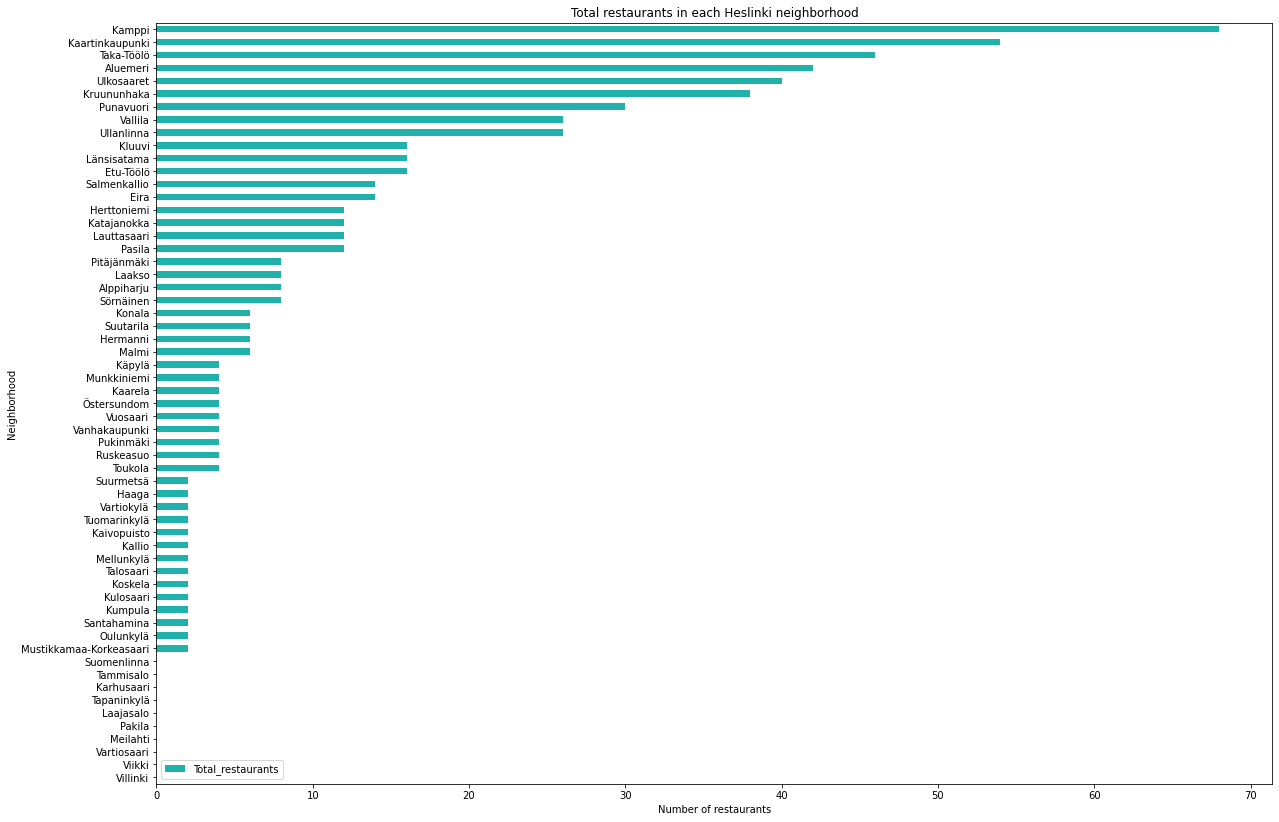

In [154]:
#Plot total restaurants of each neighborhood
data=restaurant_each_neighborhood[['Neighborhood','Total_restaurants']].set_index('Neighborhood')

data.plot(kind='barh', figsize=(20,14), color='lightseagreen').invert_yaxis()

plt.xlabel('Number of restaurants') # add to x-label to the plot
plt.ylabel('Neighborhood') # add y-label to the plot
plt.title('Total restaurants in each Heslinki neighborhood') # add title to the plot

plt.show()

From the above we can see that Kamppi, Kaartinkaupunki, Taka-Töölö, Aluemeri, Kruununhaka, Ulkosaaret, Punavuori, Vallila, Ullanlinna are neighborhoods which have a high density of restaurants.

Plot the neighborhoods by number of restaurants

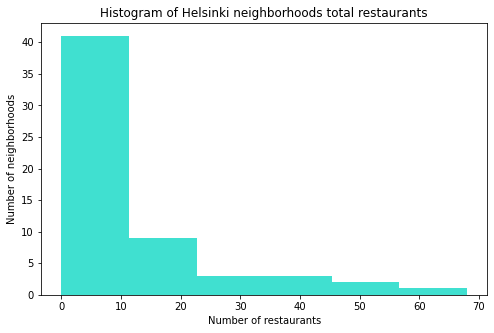

In [171]:

restaurant_each_neighborhood['Total_restaurants'].plot(kind='hist', figsize=(8, 5),bins=6,color='turquoise')

plt.title('Histogram of Helsinki neighborhoods total restaurants') # add a title to the histogram
plt.ylabel('Number of neighborhoods') # add y-label
plt.xlabel('Number of restaurants') # add x-label

plt.show()

f) Calculate the total number of each type of restaurant in Helsinki area and visualize

In [163]:
helsinki_restaurant_categories = helsinki_grouped_1_restaurant.sum(axis=0).sort_values(ascending=False).to_frame().reset_index()
helsinki_restaurant_categories.rename(columns={0 :'Total_number', 'index':'Neighborhood'}, inplace=True )
helsinki_restaurant_categories.head()

,Neighborhood,Total_number
0,Pizza Place,51
1,Scandinavian Restaurant,43
2,Restaurant,20
3,Sushi Restaurant,18
4,Chinese Restaurant,14


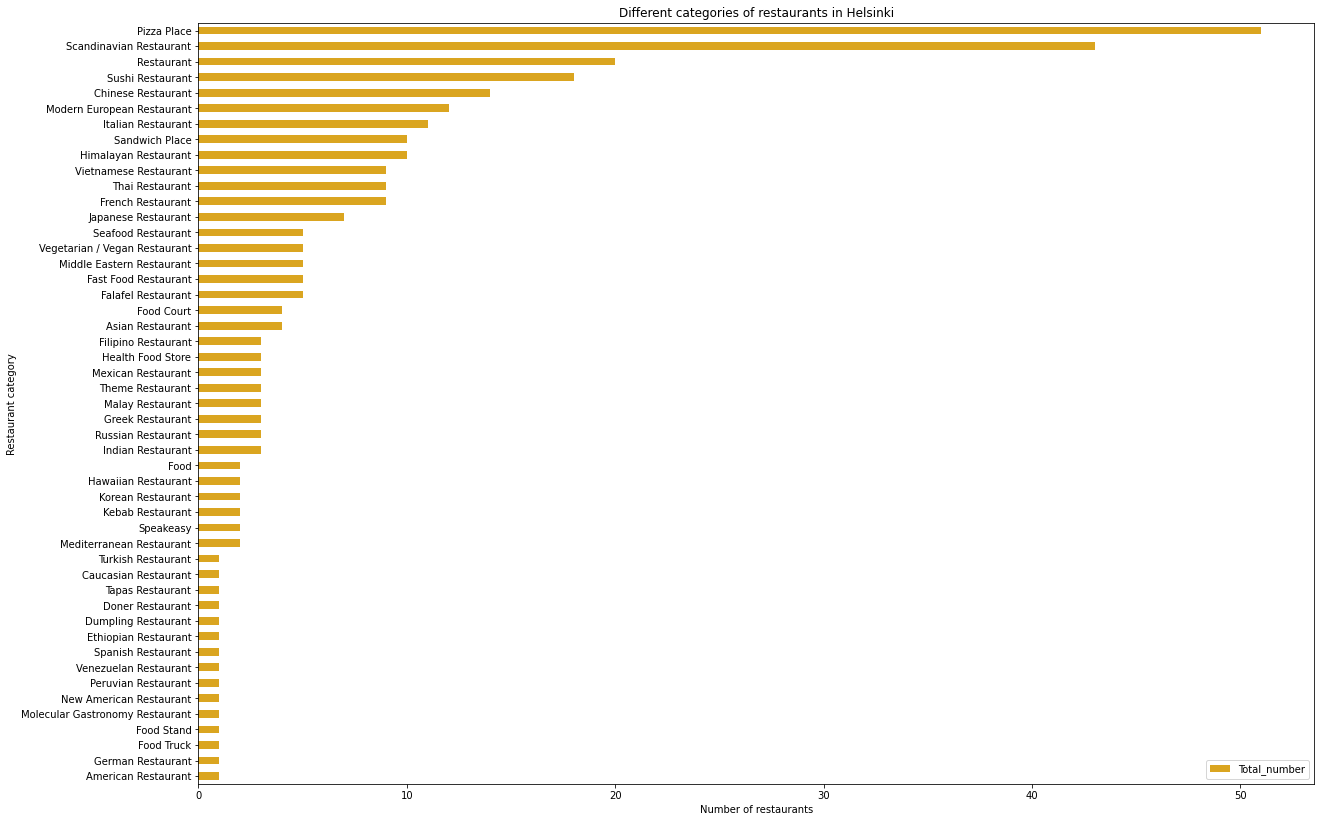

In [165]:
#Plot total restaurants of each neighborhood
data2=helsinki_restaurant_categories[['Neighborhood','Total_number']].set_index('Neighborhood')

data2.plot(kind='barh', figsize=(20,14), color='goldenrod').invert_yaxis()

plt.xlabel('Number of restaurants') # add to x-label to the plot
plt.ylabel('Restaurant category') # add y-label to the plot
plt.title('Different categories of restaurants in Helsinki') # add title to the plot

plt.show()

From the above we can see that in Helsinki area, Pizza Place and Scandinavian Restaurant are the most common restaurant types, followed by Sushi Restaurant, Chinese Restaurant and  Modern European Restaurant.

g) Find out the top 10 popular venues in Helsinki and visualize

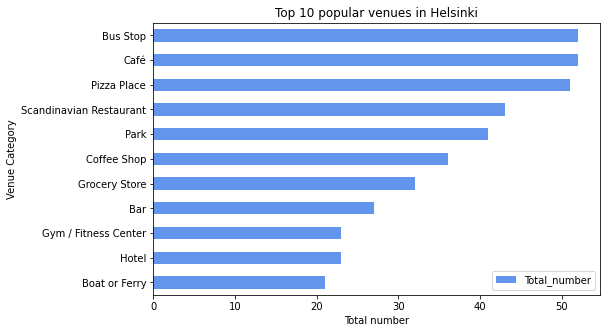

In [170]:
popular_venues = helsinki_grouped_1.set_index('Neighborhood').sum(axis=0).sort_values(ascending=False)[0:11].to_frame()

popular_venues.rename(columns={0 :'Total_number'}, inplace=True )

popular_venues.plot(kind='barh', figsize=(8,5), color='cornflowerblue').invert_yaxis()

plt.xlabel('Total number') # add to x-label to the plot
plt.ylabel('Venue Category') # add y-label to the plot
plt.title('Top 10 popular venues in Helsinki') # add title to the plot

plt.show()

From the above, we can see that in Helsinki area, there are many coffee places (in total 88 Café & Coffee Shop), bus stops, restaurants (mostly pizza places and Scandinavian Restaurant) and parks. 

h) Present the top 3 popular venues in each neighborhood

In [24]:
top3 = helsinki_venues.groupby(['Neighborhood','Venue Category']).size().reset_index(name='Counts')
top3 = top3.sort_values(['Neighborhood','Counts'],ascending=False).groupby('Neighborhood').head(3).reset_index(drop=True)

top3['Join'] = top3['Counts'].map(str) + " " + top3['Venue Category']
top3 = top3.groupby(['Neighborhood'])['Join'].apply(", ".join).reset_index()

top3.head()

,Neighborhood,Join
0,Alppiharju,"6 Theme Park Ride / Attraction, 2 Bar, 2 Greek..."
1,Aluemeri,"5 Café, 4 Boat or Ferry, 4 Scandinavian Restau..."
2,Eira,"2 Bakery, 2 Park, 1 Beach"
3,Etu-Töölö,"4 Scandinavian Restaurant, 2 Pub, 1 Asian Rest..."
4,Haaga,"1 Café, 1 Playground, 1 Sushi Restaurant"


2.2.5 Segment the neighborhoods

a) Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [32]:
helsinki_grouped = helsinki_onehot.groupby('Neighborhood').mean().reset_index()
helsinki_grouped.head()

,Neighborhood,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auditorium,Bagel Shop,...,Video Game Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Alppiharju,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aluemeri,0.0,0.0,0.0,0.016949,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.016949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Eira,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Etu-Töölö,0.0,0.0,0.0,0.000000,0.0,0.0,0.055556,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Haaga,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


b) Write a function to sort the venues based on its frequency of each neighborhood

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

c) Create a new dataframe and display the top 10 venues of each neighborhood

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = helsinki_grouped['Neighborhood']

for ind in np.arange(helsinki_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(helsinki_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alppiharju,Theme Park Ride / Attraction,Park,Bar,Greek Restaurant,Café,Thai Restaurant,Dog Run,Vietnamese Restaurant,History Museum,Theater
1,Aluemeri,Café,Boat or Ferry,Scandinavian Restaurant,Pizza Place,Grocery Store,Coffee Shop,Indie Movie Theater,Plaza,Bar,Modern European Restaurant
2,Eira,Bakery,Park,Harbor / Marina,Boat or Ferry,Scandinavian Restaurant,Café,Mexican Restaurant,Beach,Modern European Restaurant,Turkish Restaurant
3,Etu-Töölö,Scandinavian Restaurant,Pub,Bookstore,Russian Restaurant,Plaza,Indie Theater,Asian Restaurant,Gym / Fitness Center,Restaurant,Bakery
4,Haaga,Sushi Restaurant,Playground,Café,Zoo Exhibit,Falafel Restaurant,Food Stand,Food Court,Food,Flower Shop,Flea Market


d) Use elbow method to find the best K

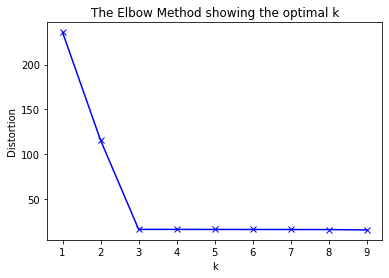

In [69]:
from scipy.spatial.distance import cdist

helsinki_grouped_clustering = helsinki_grouped.drop('Neighborhood', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(helsinki_grouped_clustering)
    distortions.append(sum(np.min(cdist(helsinki_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / helsinki_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Based on the above analysis, we choose cluster number to be 3.

d) Run K-means to cluster the neighborhood to 3 clusters

In [84]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(helsinki_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

e) Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [85]:
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels']=kmeans.labels_

# merge helsinki_neighborhood_geo with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
helsinki_merged = pd.merge(helsinki_neighborhood_geo,neighborhoods_venues_sorted, on =['Neighborhood'])

helsinki_merged.head() 

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Kruununhaka,60.17164,24.95658,Bar,Grocery Store,Café,Boat or Ferry,Pizza Place,Scandinavian Restaurant,Modern European Restaurant,Theater,Organic Grocery,German Restaurant,1
1,Kluuvi,60.17047,24.94654,Café,Scandinavian Restaurant,Clothing Store,Burger Joint,Hotel,Coffee Shop,Bistro,Park,Furniture / Home Store,Bookstore,1
2,Kaartinkaupunki,60.16486,24.94940,Scandinavian Restaurant,Hotel,Cocktail Bar,Vegetarian / Vegan Restaurant,Music Venue,French Restaurant,Furniture / Home Store,Bistro,Park,Café,1
3,Kamppi,60.16739,24.93108,Wine Bar,Coffee Shop,Scandinavian Restaurant,Chinese Restaurant,Burger Joint,Sushi Restaurant,Gym / Fitness Center,Food Court,Salon / Barbershop,Rock Club,1
4,Punavuori,60.16147,24.93726,Bakery,Coffee Shop,Pizza Place,Hotel,Scandinavian Restaurant,Sushi Restaurant,Park,Café,Gay Bar,Furniture / Home Store,1


f) Visualize the resulting clusters

In [86]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(helsinki_merged['Latitude'], helsinki_merged['Longitude'], helsinki_merged['Neighborhood'], helsinki_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

g) Present each cluster's data 

Cluster 0

In [87]:
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 0, helsinki_merged.columns[[0] + list(range(3, helsinki_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
10,Kallio,Bus Stop,Music School,Flower Shop,Taxi Stand,Grocery Store,Chinese Restaurant,Park,Dog Run,Doner Restaurant,Filipino Restaurant,0
25,Koskela,Bus Stop,Café,Pizza Place,Grocery Store,Farm,Food Truck,Food Stand,Food Court,Food,Flower Shop,0
27,Oulunkylä,Bus Stop,Grocery Store,Soccer Field,Recreation Center,Skating Rink,Fast Food Restaurant,Curling Ice,Food,Flower Shop,Flea Market,0
33,Pakila,Bus Stop,Playground,Historic Site,Grocery Store,Film Studio,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Zoo Exhibit,Falafel Restaurant,0
35,Viikki,Bus Stop,Cafeteria,Eye Doctor,Lake,Farm,Food Stand,Food Court,Food,Farmers Market,Food Truck,0
38,Tapaninkylä,Bus Stop,Gourmet Shop,Forest,Food Truck,Food Stand,Food Court,Food,Flower Shop,Flea Market,Fish & Chips Shop,0
48,Laajasalo,Bus Stop,Sauna / Steam Room,Falafel Restaurant,Food Truck,Food Stand,Food Court,Food,Flower Shop,Flea Market,Fish & Chips Shop,0
57,Karhusaari,Bus Stop,Park,Lounge,Falafel Restaurant,Food Truck,Food Stand,Food Court,Food,Flower Shop,Flea Market,0


Cluster 1

In [88]:
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 1, helsinki_merged.columns[[0] + list(range(3, helsinki_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Kruununhaka,Bar,Grocery Store,Café,Boat or Ferry,Pizza Place,Scandinavian Restaurant,Modern European Restaurant,Theater,Organic Grocery,German Restaurant,1
1,Kluuvi,Café,Scandinavian Restaurant,Clothing Store,Burger Joint,Hotel,Coffee Shop,Bistro,Park,Furniture / Home Store,Bookstore,1
2,Kaartinkaupunki,Scandinavian Restaurant,Hotel,Cocktail Bar,Vegetarian / Vegan Restaurant,Music Venue,French Restaurant,Furniture / Home Store,Bistro,Park,Café,1
3,Kamppi,Wine Bar,Coffee Shop,Scandinavian Restaurant,Chinese Restaurant,Burger Joint,Sushi Restaurant,Gym / Fitness Center,Food Court,Salon / Barbershop,Rock Club,1
4,Punavuori,Bakery,Coffee Shop,Pizza Place,Hotel,Scandinavian Restaurant,Sushi Restaurant,Park,Café,Gay Bar,Furniture / Home Store,1
5,Eira,Bakery,Park,Harbor / Marina,Boat or Ferry,Scandinavian Restaurant,Café,Mexican Restaurant,Beach,Modern European Restaurant,Turkish Restaurant,1
6,Ullanlinna,Scandinavian Restaurant,Grocery Store,Park,Ice Cream Shop,Coffee Shop,Plaza,Pharmacy,Nightclub,Boat or Ferry,Restaurant,1
7,Katajanokka,Boat or Ferry,Hotel,Park,Scandinavian Restaurant,Tram Station,Pub,Harbor / Marina,Film Studio,Café,Plaza,1
8,Kaivopuisto,Boat or Ferry,Park,Harbor / Marina,Monument / Landmark,Tram Station,Nightclub,Taxi Stand,Grocery Store,Scandinavian Restaurant,Coffee Shop,1
9,Sörnäinen,Thai Restaurant,Circus School,Cocktail Bar,Café,Dance Studio,Pizza Place,Burger Joint,Martial Arts School,Vietnamese Restaurant,Organic Grocery,1


Cluster 2

In [89]:
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 2, helsinki_merged.columns[[0] + list(range(3, helsinki_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
49,Villinki,Memorial Site,Zoo Exhibit,French Restaurant,Food Truck,Food Stand,Food Court,Food,Flower Shop,Flea Market,Fish & Chips Shop,2
